In [1]:
import os
from pathlib import Path
from collections import defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image, ImageOps, ImageFile
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchmetrics
import pytorch_lightning as pl
from torch.optim import AdamW
from torch.optim.lr_scheduler import StepLR
from torchvision import models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from torch.utils.data import DataLoader, Dataset
from pytorch_lightning import LightningModule, Trainer
from torchvision.models import ResNet18_Weights
from pytorch_lightning.callbacks import ModelCheckpoint

# Register matplotlib converters
pd.plotting.register_matplotlib_converters()

# IPython magic commands (for Jupyter notebooks)
%matplotlib inline
%load_ext autoreload
%autoreload 2

# Importing custom help tool
from help_tool import help_tool

In [2]:
train_dir = 'Archive\Split\Train'
path = Path(train_dir)

classes  = [entry.name for entry in path.iterdir() if entry.is_dir()]
classes 

['Agaricus',
 'Amanita',
 'Boletus',
 'Cortinarius',
 'Entoloma',
 'Hygrocybe',
 'Lactarius',
 'Russula',
 'Suillus']

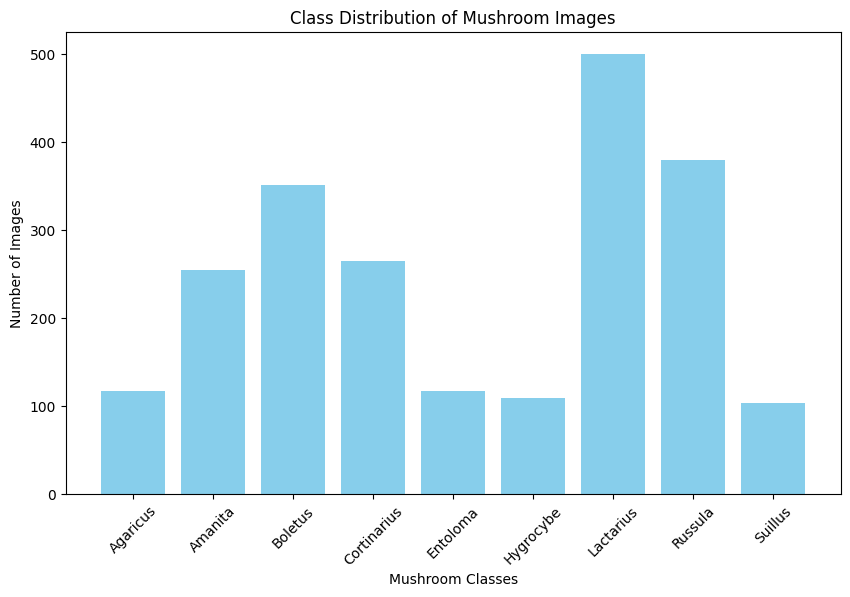

In [3]:
help_tool.plot_image_distribution(train_dir)

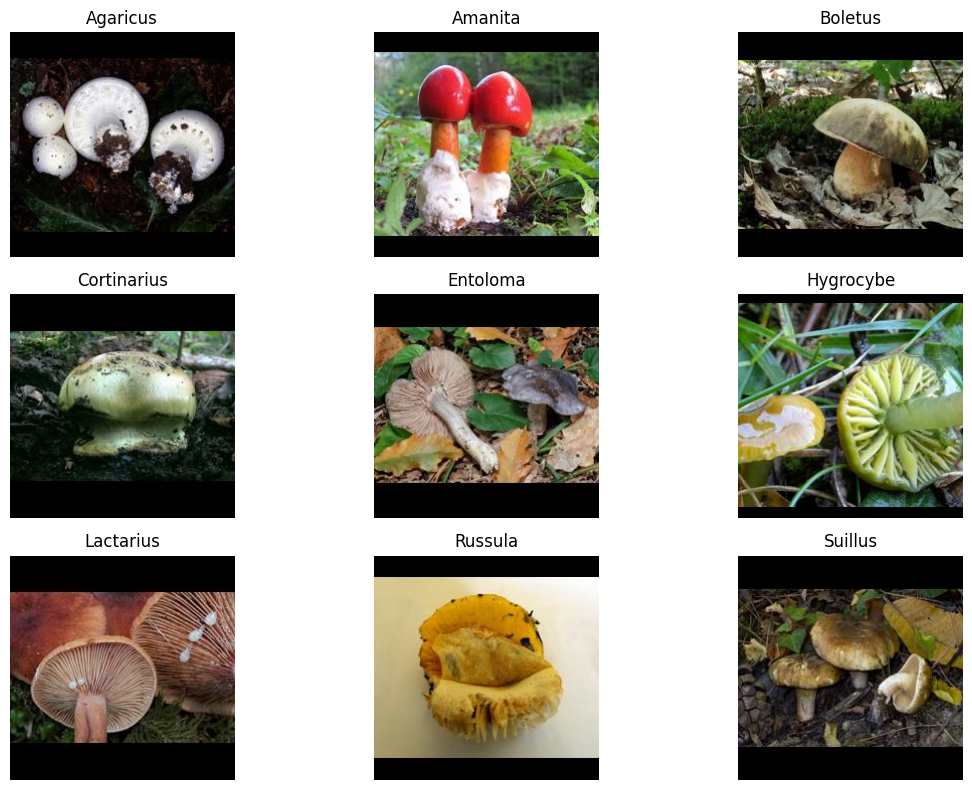

In [4]:
help_tool.visualize_sample_images(train_dir)

In [5]:
batch_size = 16

# Data Transformations

Define Data Augmentation

In [6]:
# Define the ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=50,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest'
)


val_datagen = ImageDataGenerator(rescale=1.0/255)

Convert Generators to PyTorch Tensors

In [7]:
validate_dir = 'Archive/Split/Validate'

In [8]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    validate_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 2196 images belonging to 9 classes.
Found 2060 images belonging to 9 classes.


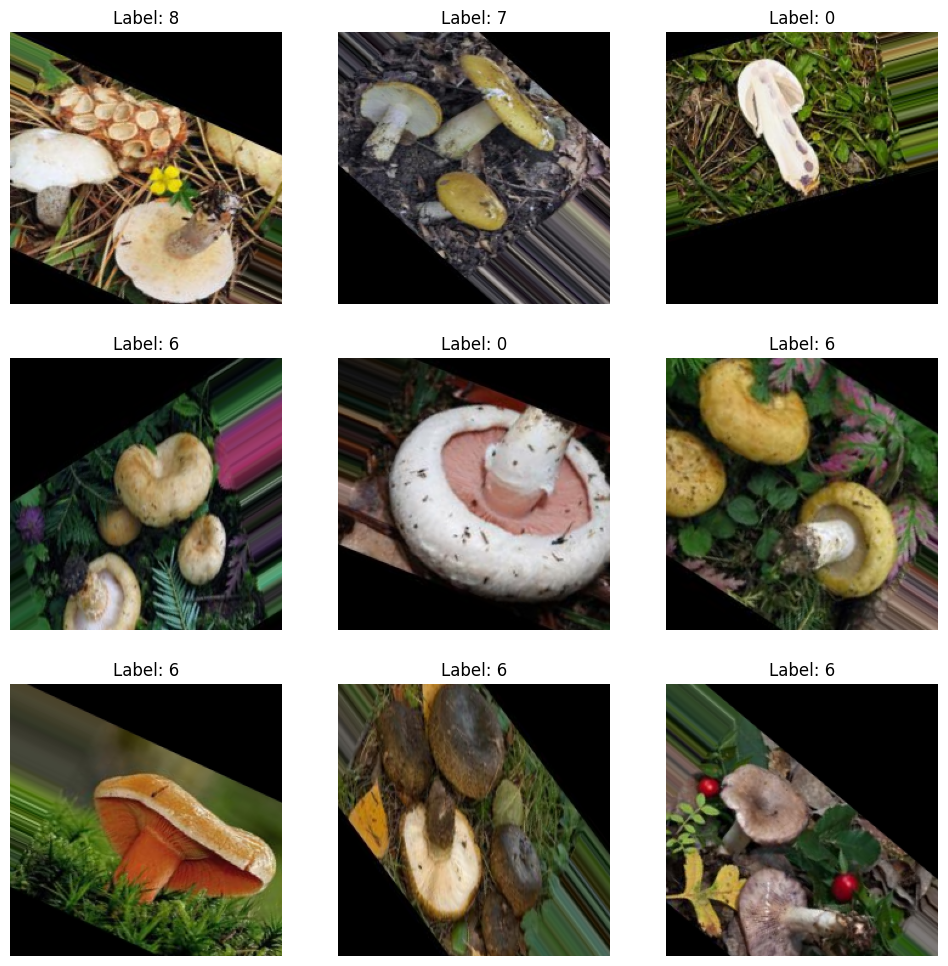

In [9]:
# Get a batch of images and labels
images, labels = next(train_generator)

# Plot a few images
plt.figure(figsize=(12, 12))
for i in range(9):  # Displaying first 9 images
    plt.subplot(3, 3, i+1)
    plt.imshow(images[i])
    plt.title(f'Label: {np.argmax(labels[i])}')
    plt.axis('off')

plt.show()


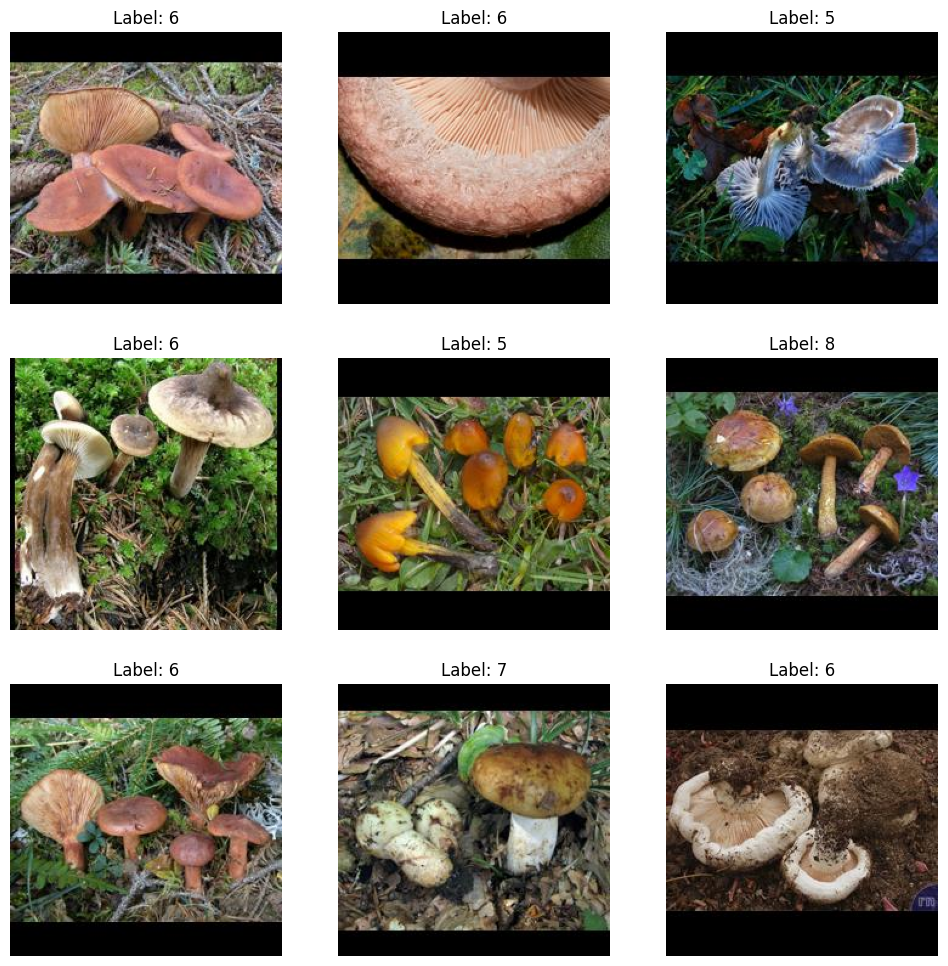

In [10]:
# Get a batch of images and labels
images, labels = next(val_generator)

# Plot a few images
plt.figure(figsize=(12, 12))
for i in range(9):  # Displaying first 9 images
    plt.subplot(3, 3, i+1)
    plt.imshow(images[i])
    plt.title(f'Label: {np.argmax(labels[i])}')
    plt.axis('off')

plt.show()


Create Data Generators

In [11]:
# class KerasImageDataset(Dataset):
#     def __init__(self, keras_generator):
#         self.generator = keras_generator

#     def __len__(self):
#         return len(self.generator)

#     def __getitem__(self, idx):
#         x, y = self.generator[idx]
#         x = torch.tensor(x, dtype=torch.float32).permute(0, 3, 1, 2)  # Convert to PyTorch tensor and reorder dimensions
#         y = torch.tensor(np.argmax(y, axis=1), dtype=torch.long)  # Convert to PyTorch tensor and get class indices
#         return x[0], y[0]
    

class KerasImageDataset(Dataset):
    def __init__(self, keras_generator):
        self.generator = keras_generator
        self.len = len(self.generator)
    
    def __len__(self):
        return self.len

    def __getitem__(self, idx):
        x, y = self.generator[idx]
        x = torch.tensor(x, dtype=torch.float32).permute(0, 3, 1, 2)  # Convert to PyTorch tensor and reorder dimensions
        y = torch.tensor(np.argmax(y, axis=1), dtype=torch.long)  # Convert to PyTorch tensor and get class indices
        return x[0], y[0]

# Create PyTorch Datasets
train_dataset = KerasImageDataset(train_generator)
val_dataset = KerasImageDataset(val_generator)


Data Loaders

In [12]:
# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, num_workers=4, shuffle=True, persistent_workers=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=4, shuffle=False, persistent_workers=True)

# Dummy Model
Dummy model with FastAI shows 70% Accuracy.

In [13]:
from fastai.vision.all import *

# Step 1: Load your data
path = Path('Archive\Split')
dls = ImageDataLoaders.from_folder(path, train='Train', valid='Validate', item_tfms=Resize(224))


# Step 2: Create a learner with appropriate metrics
learn = vision_learner(
    dls, 
    resnet18, 
    metrics=[
        accuracy, 
        Precision(average='macro'), 
        Recall(average='macro'), 
        F1Score(average='macro')
    ]
)

# Step 3: Train the model
learn.fine_tune(epochs=5)

# Step 4: Evaluate the model
results = learn.validate()
print(f"Validation results - Loss: {results[0]:.2f}, Accuracy: {results[1]:.2f}, Precision: {results[2]:.2f}, Recall: {results[3]:.2f}, F1 Score: {results[4]:.2f}")


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,2.594553,1.281528,0.599029,0.545158,0.536102,0.533310,01:25


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,1.317595,1.108657,0.648058,0.602939,0.595808,0.596817,01:45
1,0.923893,1.013177,0.671845,0.634470,0.610572,0.614385,01:45
2,0.548657,0.989253,0.698058,0.674055,0.641225,0.653538,01:41


KeyboardInterrupt: 

In [ ]:
# Step 5: Make predictions
img = PILImage.create('Archive\Split\Test\Suillus\\068_vev9iMcQQU8.jpg')
pred, pred_idx, probs = learn.predict(img)
print(f"Prediction: {pred}, Probability: {probs[pred_idx]:.4f}")

In [ ]:
# Step 5: Make predictions
img = PILImage.create('Archive\Split\Test\Lactarius\\0057_vo2wCaUiwF0.jpg')
pred, pred_idx, probs = learn.predict(img)
print(f"Prediction: {pred}, Probability: {probs[pred_idx]:.4f}")

In [ ]:
# Step 5: Make predictions
img = PILImage.create('Archive\Split\Test\Lactarius\\0057_vo2wCaUiwF0.jpg')
pred, pred_idx, probs = learn.predict(img)
print(f"Prediction: {pred}, Probability: {probs[pred_idx]:.4f}")

# Step 6: Save and load the model
learn.save('model_name')
learn.load('model_name')

# Model

In [19]:
len(classes)

9

Load and Modify ResNet18:
* models.resnet18(pretrained=True) loads the pretrained ResNet18 model.
* self.model.fc = nn.Linear(self.model.fc.in_features, num_classes) replaces the final fully connected layer to output the correct number of classes.

Define the LightningModule:
* forward: Defines the forward pass.
* training_step: Computes the training loss.
* validation_step: Computes the validation loss.
* configure_optimizers: Configures the optimizer.

Train the Model:
* Trainer(max_epochs=10): Creates a Trainer object to train the model for 10 epochs.
* trainer.fit(model, train_loader, val_loader): Starts the training process using the specified training and validation data loaders.

* ADAM: Combines weight decay with the gradient update, which can result in a less effective regularization method because the weight decay term is scaled by the learning rate and the adaptive moment estimates.
* ADAMW: Decouples weight decay from the gradient update, applying it directly to the weights after the gradient update. This approach leads to a more effective regularization method that can improve model generalization and is conceptually clearer.

In [13]:
class MyLightningModule(LightningModule):
    def __init__(self, num_classes, learning_rate=1e-3, weight_decay=1e-2, scheduler_step_size=10, scheduler_gamma=0.1):
        super(MyLightningModule, self).__init__()
        self.learning_rate = learning_rate
        self.weight_decay = weight_decay
        self.scheduler_step_size = scheduler_step_size
        self.scheduler_gamma = scheduler_gamma
        self.save_hyperparameters()
        
        self.model = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
        
        # Freeze all the layers
        for param in self.model.parameters():
            param.requires_grad = False
        # Replace the final fully connected layer
        num_ftrs = self.model.fc.in_features
        self.model.fc = nn.Linear(num_ftrs, num_classes)
        self.criterion = nn.CrossEntropyLoss()

        # Metrics
        self.train_accuracy = torchmetrics.Accuracy(task='multiclass', num_classes=num_classes)
        self.train_precision = torchmetrics.Precision(task='multiclass', num_classes=num_classes, average='macro')
        self.train_recall = torchmetrics.Recall(task='multiclass', num_classes=num_classes, average='macro')
        self.train_f1 = torchmetrics.F1Score(task='multiclass', num_classes=num_classes, average='macro')

        self.val_accuracy = torchmetrics.Accuracy(task='multiclass', num_classes=num_classes)
        self.val_precision = torchmetrics.Precision(task='multiclass', num_classes=num_classes, average='macro')
        self.val_recall = torchmetrics.Recall(task='multiclass', num_classes=num_classes, average='macro')
        self.val_f1 = torchmetrics.F1Score(task='multiclass', num_classes=num_classes, average='macro')

    def forward(self, x):
        """Defines the forward pass"""
        return self.model(x)

    def training_step(self, batch, batch_idx):
        """Computes the training loss and metrics"""
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)

        # Log loss
        self.log('train_loss', loss)

        # Log metrics
        self.train_accuracy(y_hat, y)
        self.train_precision(y_hat, y)
        self.train_recall(y_hat, y)
        self.train_f1(y_hat, y)
        
        self.log('train_accuracy', self.train_accuracy, prog_bar=True)
        self.log('train_precision', self.train_precision, prog_bar=True)
        self.log('train_recall', self.train_recall, prog_bar=True)
        self.log('train_f1', self.train_f1, prog_bar=True)

        return loss

    def validation_step(self, batch, batch_idx):
        """Computes the validation loss and metrics"""
        x, y = batch
        y_hat = self(x)
        val_loss = self.criterion(y_hat, y)
        
        # Log loss
        self.log('val_loss', val_loss, prog_bar=True)

        # Log metrics
        self.val_accuracy(y_hat, y)
        self.val_precision(y_hat, y)
        self.val_recall(y_hat, y)
        self.val_f1(y_hat, y)
        
        self.log('val_accuracy', self.val_accuracy, prog_bar=True)
        self.log('val_precision', self.val_precision, prog_bar=True)
        self.log('val_recall', self.val_recall, prog_bar=True)
        self.log('val_f1', self.val_f1, prog_bar=True)

        return val_loss

    def configure_optimizers(self):
        """Configures the optimizer and scheduler"""
        optimizer = AdamW(self.parameters(), lr=self.learning_rate, weight_decay=self.weight_decay)
        scheduler = StepLR(optimizer, step_size=self.scheduler_step_size, gamma=self.scheduler_gamma)
        return {'optimizer': optimizer, 'lr_scheduler': scheduler}

# Instantiate the model
num_classes = len(classes)
model = MyLightningModule(num_classes=num_classes, learning_rate=1e-1, weight_decay=1e-1, scheduler_step_size=10, scheduler_gamma=0.1)

# Define the checkpoint callback
checkpoint_callback = ModelCheckpoint(
    monitor='val_accuracy',  
    mode='max',
    save_top_k=1,
    verbose=True,
    dirpath='checkpoints',
    filename='mushroom-classifier-{epoch:02d}-{val_accuracy:.2f}'  # Ensure 'val_accuracy' is used here as well
)

# Assuming train_loader and val_loader are already defined DataLoader instances
trainer = Trainer(max_epochs=35, 
                  callbacks=[checkpoint_callback], 
                  log_every_n_steps=1)
trainer.fit(model, train_loader, val_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type                | Params | Mode 
----------------------------------------------------------------
0 | model           | ResNet              | 11.2 M | train
1 | criterion       | CrossEntropyLoss    | 0      | train
2 | train_accuracy  | MulticlassAccuracy  | 0      | train
3 | train_precision | MulticlassPrecision | 0      | train
4 | train_recall    | MulticlassRecall    | 0      | train
5 | train_f1        | MulticlassF1Score   | 0      | train
6 | val_accuracy    | MulticlassAccuracy  | 0      | train
7 | val_precision   | MulticlassPrecision | 0      | train
8 | val_recall      | MulticlassRecall    | 0      | train
9 | val_f1          | MulticlassF1Score   | 0      | train
----------------------------------------------------------------
4.6 K     Trainable params
11.2 M    Non-trainable params
11.2

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

In [16]:
print(torch.cuda.is_available())

False


In [35]:
class ResNet18FeatureExtractor(pl.LightningModule):
    def __init__(self):
        super(ResNet18FeatureExtractor, self).__init__()
        # Load the pretrained ResNet-18 model
        self.resnet18 = models.resnet18(weights=ResNet18_Weights.DEFAULT)
        # Remove the final fully connected layer
        self.feature_extractor = nn.Sequential(*list(self.resnet18.children())[:-1])
        
    def forward(self, x):
        # Extract features
        with torch.no_grad():
            features = self.feature_extractor(x)
        return features

In [36]:
# Instantiate the feature extractor
feature_extractor = ResNet18FeatureExtractor()

# Move the model to the appropriate device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
feature_extractor = feature_extractor.to(device)

# Define a function to preprocess an image and extract features
def extract_features(image_path, model, device):
    # Define the image transformations
    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    # Load and preprocess the image
    image = Image.open(image_path).convert('RGB')
    image = preprocess(image).unsqueeze(0) 
    image = image.to(device)

    # Extract features
    model.eval()
    with torch.no_grad():
        features = model(image)
    
    return features


In [37]:
# Example usage
image_path = 'Archive\Split\Test\Russula\\030_VXUnMqAEMHo.jpg'
features = extract_features(image_path, feature_extractor, device)
print(features.shape)  # Should be [1, 512, 1, 1] for ResNet-18

torch.Size([1, 512, 1, 1])


In [38]:
class TransferLearningModel(pl.LightningModule):
    def __init__(self, num_classes):
        super(TransferLearningModel, self).__init__()
        # Load the pretrained ResNet-18 model
        self.resnet18 = models.resnet18(weights=ResNet18_Weights.DEFAULT)
        # Remove the final fully connected layer
        self.feature_extractor = nn.Sequential(*list(self.resnet18.children())[:-1])
        # Add a new fully connected layer for the new task
        self.fc = nn.Linear(self.resnet18.fc.in_features, num_classes)

        
    def forward(self, x):
        # Extract features
        with torch.no_grad():
            features = self.feature_extractor(x)
        features = features.view(features.size(0), -1)
        # Classify
        output = self.fc(features)
        return output
    
    def training_step(self, batch, batch_idx):
        images, labels = batch
        outputs = self(images)
        loss = nn.CrossEntropyLoss()(outputs, labels)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        images, labels = batch
        outputs = self(images)
        loss = nn.CrossEntropyLoss()(outputs, labels)
        self.log('val_loss', loss)
        return loss
    
    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
        return optimizer


In [39]:
num_classes = len(classes)
model = TransferLearningModel(num_classes)

In [40]:
trainer = pl.Trainer(max_epochs=5)
trainer.fit(model, train_loader, val_loader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name              | Type       | Params | Mode 
---------------------------------------------------------
0 | resnet18          | ResNet     | 11.7 M | train
1 | feature_extractor | Sequential | 11.2 M | train
2 | fc                | Linear     | 4.6 K  | train
---------------------------------------------------------
11.7 M    Trainable params
0         Non-trainable params
11.7 M    Total params
46.777    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

In [15]:
class MyLightningModule(LightningModule):
    def __init__(self, num_classes, learning_rate=1e-3, weight_decay=1e-2, scheduler_step_size=10, scheduler_gamma=0.1):
        super(MyLightningModule, self).__init__()
        self.learning_rate = learning_rate
        self.weight_decay = weight_decay
        self.scheduler_step_size = scheduler_step_size
        self.scheduler_gamma = scheduler_gamma
        self.save_hyperparameters()
        
        self.model = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
        
        # Freeze all the layers
        for param in self.model.parameters():
            param.requires_grad = False
        # Replace the final fully connected layer
        num_ftrs = self.model.fc.in_features
        self.model.fc = nn.Linear(num_ftrs, num_classes)
        self.criterion = nn.CrossEntropyLoss()

        # Metrics
        self.train_accuracy = torchmetrics.Accuracy(task='multiclass', num_classes=num_classes)
        self.train_precision = torchmetrics.Precision(task='multiclass', num_classes=num_classes, average='macro')
        self.train_recall = torchmetrics.Recall(task='multiclass', num_classes=num_classes, average='macro')
        self.train_f1 = torchmetrics.F1Score(task='multiclass', num_classes=num_classes, average='macro')

        self.val_accuracy = torchmetrics.Accuracy(task='multiclass', num_classes=num_classes)
        self.val_precision = torchmetrics.Precision(task='multiclass', num_classes=num_classes, average='macro')
        self.val_recall = torchmetrics.Recall(task='multiclass', num_classes=num_classes, average='macro')
        self.val_f1 = torchmetrics.F1Score(task='multiclass', num_classes=num_classes, average='macro')

    def forward(self, x):
        """Defines the forward pass"""
        return self.model(x)

    def training_step(self, batch, batch_idx):
        """Computes the training loss and metrics"""
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)

        # Log loss
        self.log('train_loss', loss)

        # Log metrics
        self.train_accuracy(y_hat, y)
        self.train_precision(y_hat, y)
        self.train_recall(y_hat, y)
        self.train_f1(y_hat, y)
        
        self.log('train_accuracy', self.train_accuracy, prog_bar=True)
        self.log('train_precision', self.train_precision, prog_bar=True)
        self.log('train_recall', self.train_recall, prog_bar=True)
        self.log('train_f1', self.train_f1, prog_bar=True)

        return loss

    def validation_step(self, batch, batch_idx):
        """Computes the validation loss and metrics"""
        x, y = batch
        y_hat = self(x)
        val_loss = self.criterion(y_hat, y)
        
        # Log loss
        self.log('val_loss', val_loss, prog_bar=True)

        # Log metrics
        self.val_accuracy(y_hat, y)
        self.val_precision(y_hat, y)
        self.val_recall(y_hat, y)
        self.val_f1(y_hat, y)
        
        self.log('val_accuracy', self.val_accuracy, prog_bar=True)
        self.log('val_precision', self.val_precision, prog_bar=True)
        self.log('val_recall', self.val_recall, prog_bar=True)
        self.log('val_f1', self.val_f1, prog_bar=True)

        return val_loss

    def configure_optimizers(self):
        """Configures the optimizer and scheduler"""
        optimizer = AdamW(self.parameters(), lr=self.learning_rate, weight_decay=self.weight_decay)
        scheduler = StepLR(optimizer, step_size=self.scheduler_step_size, gamma=self.scheduler_gamma)
        return {'optimizer': optimizer, 'lr_scheduler': scheduler}

# Instantiate the model
num_classes = len(classes)
model = MyLightningModule(num_classes=num_classes, learning_rate=1e-1, weight_decay=1e-1, scheduler_step_size=10, scheduler_gamma=0.1)

# Define the checkpoint callback
checkpoint_callback = ModelCheckpoint(
    monitor='val_accuracy',  
    mode='max',
    save_top_k=1,
    verbose=True,
    dirpath='checkpoints',
    filename='mushroom-classifier-{epoch:02d}-{val_accuracy:.2f}'  # Ensure 'val_accuracy' is used here as well
)

# Assuming train_loader and val_loader are already defined DataLoader instances
trainer = Trainer(max_epochs=35, 
                  callbacks=[checkpoint_callback], 
                  log_every_n_steps=1)
trainer.fit(model, train_loader, val_loader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type                | Params | Mode 
----------------------------------------------------------------
0 | model           | ResNet              | 11.2 M | train
1 | criterion       | CrossEntropyLoss    | 0      | train
2 | train_accuracy  | MulticlassAccuracy  | 0      | train
3 | train_precision | MulticlassPrecision | 0      | train
4 | train_recall    | MulticlassRecall    | 0      | train
5 | train_f1        | MulticlassF1Score   | 0      | train
6 | val_accuracy    | MulticlassAccuracy  | 0      | train
7 | val_precision   | MulticlassPrecision | 0      | train
8 | val_recall      | MulticlassRecall    | 0      | train
9 | val_f1          | MulticlassF1Score   | 0      | train
----------------------------------------------------------------
4.6 K     Trainable params
11.2 M    Non-trainable params
11.2 M    Total params
44.725    Total estimated mo

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

In [34]:
# model = MyLightningModule.load_from_checkpoint("checkpoints\mushroom-classifier-epoch=12-val_accuracy=0.42.ckpt")

In [40]:
# from pytorch_lightning import Trainer

# # Load the model from checkpoint
# model = MyLightningModule.load_from_checkpoint("checkpoints\mushroom-classifier-epoch=12-val_accuracy=0.42.ckpt")

# # Create an optimizer instance as per the model's configuration
# optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)  # lr is initial, real lr is in state_dict

# # Load the optimizer state into the new optimizer
# optimizer.load_state_dict(checkpoint['optimizer_states'][0])

# # Inspect the learning rate from the optimizer state
# for param_group in optimizer.param_groups:
#     print(f"Learning rate: {param_group['lr']}")


Learning rate: 0.010000000000000002


In [44]:
# checkpoint.get('epoch', None)

12

In [48]:
# import torch
# from torchmetrics import Accuracy, Precision, Recall, F1Score
# from torch.utils.data import DataLoader


# model.eval()  # Set the model to evaluation mode

# # Define metrics
# num_classes = model.hparams.num_classes
# accuracy = Accuracy(task='multiclass', num_classes=num_classes)
# precision = Precision(task='multiclass', num_classes=num_classes, average='macro')
# recall = Recall(task='multiclass', num_classes=num_classes, average='macro')
# f1 = F1Score(task='multiclass', num_classes=num_classes, average='macro')

# # Prepare your DataLoader for validation
# val_loader = DataLoader(val_dataset, batch_size=32, num_workers=4, shuffle=False)

# # Evaluate the model
# for batch in val_loader:
#     x, y = batch
#     with torch.no_grad():
#         y_hat = model(x)
#         # Compute metrics
#         accuracy.update(y_hat, y)
#         precision.update(y_hat, y)
#         recall.update(y_hat, y)
#         f1.update(y_hat, y)

# # Compute final metrics
# print(f"Accuracy: {accuracy.compute()}")
# print(f"Precision: {precision.compute()}")
# print(f"Recall: {recall.compute()}")
# print(f"F1 Score: {f1.compute()}")


checkpoint.keys()